In [1]:
# source: https://www.kaggle.com/nobletp/panda-keras-baseline

In [2]:
#python3 effnb3.py --cnnpar effnB3 --mfolder effnB3_1

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os, argparse
import cv2
import numpy as np
import pandas as pd 
import json
import skimage.io
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
#import albumentations as albu
print('tensorflow version:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('no gpus')

tensorflow version: 2.2.0
no gpus


In [4]:
import panda_bvv_config
from panda_bvv_config import *

In [5]:
ap = argparse.ArgumentParser()
ap.add_argument('--cnnpar', type=str, help="parameters name", dest = 'cnn_parameters', default = 'effnB2')
ap.add_argument('--mfolder', help="folder to save model files", dest = 'mfolder', default = 'effnB2_model',\
                type=str)
                #("--cnn", type=str, help="training cnn name", dest = 'train_cnn')
args = vars(ap.parse_args())

In [6]:
#FOR TEST:
# cnnet = 'effnB2_test'
# model_save_folder = 'effnB2test'


In [7]:
#FOR TRAIN:
cnnet = args["cnn_parameters"]
model_save_folder = args["mfolder"]

In [8]:
#constant train parameters
learn_rate = 3e-3
inp_patience = 14
inp_label_smooth = 0.15

In [9]:
class_weights = panda_bvv_config.class_weights
input_parameters = panda_bvv_config.train_dict.get(cnnet)

image_sizey = input_parameters.get('image_sizey')
image_sizex = input_parameters.get('image_sizex')
num_epochs = input_parameters.get('num_epochs')
BS = input_parameters.get('BS')
s_per_epoch = input_parameters.get('s_per_epoch')
val_steps = input_parameters.get('val_steps')
model_name = input_parameters.get('model_name')
checkpoint_name = input_parameters.get('checkpoint_name')
weights_file = input_parameters.get('weights_file')
file_for_struct = input_parameters.get('file_for_struct')
file_for_weights = input_parameters.get('file_for_weights')
history_file = input_parameters.get('history_file')
save_plot_file = input_parameters.get('save_plot_file')

input_shape_ =(image_sizey, image_sizex , 3)

In [10]:
print('CNN input parameters: {}'.format(input_parameters))

CNN input parameters: {'image_sizey': 260, 'image_sizex': 260, 'num_epochs': 2, 'num_earlyStop': 2, 'num_reduceOnPlateu': 8, 'BS': 10, 's_per_epoch': 12, 'val_steps': 4, 'model_name': 'model_panda.h5', 'checkpoint_name': 'model_effnB2_panda_check', 'weights_file': 'efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5', 'file_for_struct': 'model_effnB2_panda_struct.json', 'file_for_weights': 'model_effnB2_panda_weights.json', 'history_file': 'history_effnB2.json', 'save_plot_file': 'plot_edu_effnb2.png'}


In [11]:
full_model_save_folder_path = os.path.join(note_path, model_save_folder)
if not os.path.exists(full_model_save_folder_path):
    print("[INFO] 'creating {}' directory".format(model_save_folder))
    os.makedirs(full_model_save_folder_path)
model_name = os.path.join(full_model_save_folder_path, model_name)
checkpoint_name = os.path.join(full_model_save_folder_path, checkpoint_name)

weights_file = os.path.join(note_path, weights_file) #!:not the same path

file_for_struct = os.path.join(full_model_save_folder_path, file_for_struct)
file_for_weights = os.path.join(full_model_save_folder_path, file_for_weights)
history_file = os.path.join(full_model_save_folder_path, history_file)
save_plot_file = os.path.join(full_model_save_folder_path, save_plot_file)


In [12]:
bottleneck = efn.EfficientNetB2(
    input_shape=input_shape_,
    weights= weights_file,
    include_top=False, 
    pooling='avg'
)
bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
model = Sequential()
model.add(bottleneck)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(6, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 9, 9, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1408)              5632      
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [14]:
model.compile(
    loss  = tf.keras.losses.CategoricalCrossentropy(label_smoothing = inp_label_smooth),
    #loss='categorical_crossentropy',
    optimizer=Adam(lr=learn_rate),
    metrics=['categorical_accuracy'] #, kappa_keras]
)

In [15]:
train_generator = ImageDataGenerator(rescale=1/255.0,
                                    rotation_range=20,
                                    zoom_range=0.05,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    #shear_range=0.05,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    #fill_mode="nearest"
                                    )

val_generator = ImageDataGenerator(rescale=1/255.0)

In [16]:
train_datagen = train_generator.flow_from_directory(
        train_cnn,
        target_size=(image_sizey, image_sizex),
        color_mode="rgb",
        batch_size= BS,
        shuffle=True,
        class_mode='categorical')


Found 1201 images belonging to 6 classes.


In [17]:
val_datagen = val_generator.flow_from_directory(
        valid_cnn,
        target_size=(image_sizey, image_sizex),
        color_mode="rgb",
        batch_size = BS,
        shuffle=False,
        class_mode='categorical')

Found 1201 images belonging to 6 classes.


In [18]:
callbacks_list = [
        EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        mode = 'min',
        min_delta=1e-2,
        patience=inp_patience,
        verbose=1,
        restore_best_weights = True
        ),
        
        ModelCheckpoint(
        filepath= checkpoint_name +".{epoch:02d}.h5",
        monitor='val_loss',
        mode = 'auto',
        save_weights_only = False,
        save_freq = 'epoch',
        save_best_only=False
        ),
    
        ReduceLROnPlateau(
        monitor='val_loss',
        factor=.1,
        patience=5,
        verbose=1,
        min_lr=1e-7
        )
]

In [19]:
history = model.fit_generator(
    train_datagen,
    steps_per_epoch=s_per_epoch,
    validation_data=val_datagen,
    validation_steps=val_steps,
    class_weight=class_weights,
    callbacks=callbacks_list,
    epochs=num_epochs,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
12/12 [==============================] - 48s 4s/step - loss: 8.8463 - categorical_accuracy: 0.3083 - val_loss: 2.2411 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0030
Epoch 2/2
12/12 [==============================] - 46s 4s/step - loss: 6.6433 - categorical_accuracy: 0.2417 - val_loss: 57.6459 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0030


In [20]:
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)


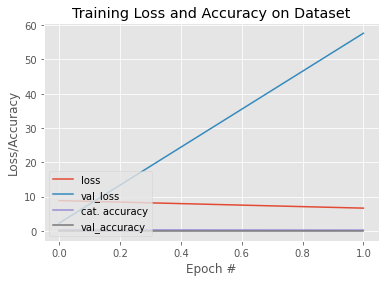

In [21]:
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, num_epochs), history.history['loss'], label='loss')
plt.plot(np.arange(0, num_epochs), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs),history.history['categorical_accuracy'], label='cat. accuracy')
plt.plot(np.arange(0, num_epochs),history.history['val_categorical_accuracy'], label='val_accuracy')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(save_plot_file)

In [22]:
model.save(model_name)
model.save_weights(file_for_weights, save_format="h5")
json_config = model.to_json()
with open(file_for_struct, 'w') as f:
    json.dump(json_config, f)

In [23]:
import os
module_name = 'effnB2'

os.system('jupyter nbconvert --to python ' + module_name + '.ipynb')
with open(module_name + '.py', 'r') as f:
    lines = f.readlines()
with open(module_name + '.py', 'w') as f:
    for line in lines:
        if 'nbconvert --to python' in line:
            break
        else:
            f.write(line)